## Coursera Capstone Project - Week # 3

# Segmenting and Clustering Neighborhoods in Toronto




================================================================================================================


### 0) Main python libraries used

In [1]:
# Data analysis
import numpy as np # library for vectorized computation
import pandas as pd # library to process data as dataframes

# Data Scraping
import requests # library to handle requests
import bs4 as bs
from bs4 import BeautifulSoup

# To get latitude and longitude
!conda install -c conda-forge geocoder --yes
import geocoder

# To convert an address into latitude and longitude values
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Maps
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

# K-Means clustering
from sklearn.cluster import KMeans

# Plots
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.



### 1) Scraping data using BeautifulSoup and create data_frame

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M" # URL from wikipedia
data  = requests.get(url).text

In [3]:
soup = BeautifulSoup(data, 'html5lib')

In [4]:
tables = soup.find('table')
len(tables)

2

In [5]:
print(tables.prettify())

<table cellpadding="2" cellspacing="0" rules="all" style="width:100%;">
 <tbody>
  <tr>
   <td style="width:11%;">
    <p>
     M1A
     <br/>
     <span style="font-size:85%;">
      Not assigned
     </span>
    </p>
   </td>
   <td style="width:11%;">
    <p>
     M2A
     <br/>
     <span style="font-size:85%;">
      Not assigned
     </span>
    </p>
   </td>
   <td style="width:11%;">
    <p>
     M3A
     <br/>
     <span style="font-size:85%;">
      <a href="/wiki/North_York" title="North York">
       North York
      </a>
      <br/>
      (
      <a href="/wiki/Parkwoods" title="Parkwoods">
       Parkwoods
      </a>
      )
     </span>
    </p>
   </td>
   <td style="width:11%;">
    <p>
     M4A
     <br/>
     <span style="font-size:85%;">
      <a href="/wiki/North_York" title="North York">
       North York
      </a>
      <br/>
      (
      <a href="/wiki/Victoria_Village" title="Victoria Village">
       Victoria Village
      </a>
      )
     </span>
    </p>


In [6]:
table_contents=[]
table = soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})


df

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto Business,Enclave of M4L
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [7]:
df.shape

(103, 3)

In [8]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df['Borough'].unique()),
        df.shape[0]))

The dataframe has 15 boroughs and 103 neighborhoods.


### 2) Get the latitude and the longitude coordinates of each neighborhood using Geocoder and add them to data frame

In [9]:
# create empty list for latitude and longitude
latitude, longitude = [], []

In [10]:
for i in range(df.shape[0]):

    # initialize your variable to None
    lat_lng_coords = None

    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(df['PostalCode'][i])) #postal_code
        lat_lng_coords = g.latlng

    latitude.append(lat_lng_coords[0])
    longitude.append(lat_lng_coords[1])
    print(i)
print('completed')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
completed


In [11]:
df['Latitude'] = latitude
df['Longitude'] = longitude
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.75245,-79.32991
1,M4A,North York,Victoria Village,43.73057,-79.31306
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042
4,M7A,Queen's Park,Ontario Provincial Government,43.66253,-79.39188


## 3) Explore and cluster the neighborhoods in Toronto

Note: Only boroughs that contain the word Toronto

In [12]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
trt_latitude = location.latitude
trt_longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(trt_latitude, trt_longitude))

The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.


In [13]:
df.shape

(103, 5)

In [14]:
df['Borough'].value_counts()

North York                24
Downtown Toronto          17
Scarborough               17
Etobicoke                 11
Central Toronto            9
West Toronto               6
York                       5
East Toronto               4
East York                  4
Mississauga                1
Downtown Toronto Stn A     1
Queen's Park               1
East York/East Toronto     1
Etobicoke Northwest        1
East Toronto Business      1
Name: Borough, dtype: int64

In [15]:
for i in range(df.shape[0]):
    if "Toronto" in df['Borough'][i]:
        print(i)
    else :
        df.drop([i], inplace=True)

2
9
15
19
20
24
25
30
31
35
36
37
41
42
43
47
48
54
61
62
67
68
69
73
74
75
79
80
81
83
84
86
87
91
92
96
97
99
100


In [16]:
df.reset_index(drop=True, inplace=True)
df

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.65739,-79.37804
2,M5C,Downtown Toronto,St. James Town,43.65215,-79.37587
3,M4E,East Toronto,The Beaches,43.67709,-79.29547
4,M5E,Downtown Toronto,Berczy Park,43.64536,-79.37306
5,M5G,Downtown Toronto,Central Bay Street,43.65609,-79.38493
6,M6G,Downtown Toronto,Christie,43.66869,-79.42071
7,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.64970,-79.38258
8,M6H,West Toronto,"Dufferin, Dovercourt Village",43.66505,-79.43891
9,M4J,East York/East Toronto,The Danforth East,43.68811,-79.33418


In [17]:
df['Borough'].value_counts()

Downtown Toronto          17
Central Toronto            9
West Toronto               6
East Toronto               4
East Toronto Business      1
Downtown Toronto Stn A     1
East York/East Toronto     1
Name: Borough, dtype: int64

In [18]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[trt_latitude, trt_longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhoods in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhoods, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [19]:
# Define inputs X to each area of Postal Code
X = [df['Latitude'], df['Longitude']]
X = np.array(X).T
X

array([[ 43.65512, -79.36264],
       [ 43.65739, -79.37804],
       [ 43.65215, -79.37587],
       [ 43.67709, -79.29547],
       [ 43.64536, -79.37306],
       [ 43.65609, -79.38493],
       [ 43.66869, -79.42071],
       [ 43.6497 , -79.38258],
       [ 43.66505, -79.43891],
       [ 43.68811, -79.33418],
       [ 43.64285, -79.38076],
       [ 43.64848, -79.41774],
       [ 43.68375, -79.35512],
       [ 43.6471 , -79.38153],
       [ 43.63941, -79.42676],
       [ 43.66797, -79.31467],
       [ 43.6484 , -79.37914],
       [ 43.66213, -79.33497],
       [ 43.72843, -79.38713],
       [ 43.71208, -79.41848],
       [ 43.71276, -79.38851],
       [ 43.69479, -79.4144 ],
       [ 43.65973, -79.46281],
       [ 43.71458, -79.40668],
       [ 43.67484, -79.40452],
       [ 43.64777, -79.44989],
       [ 43.7034 , -79.38659],
       [ 43.66311, -79.4018 ],
       [ 43.64982, -79.47548],
       [ 43.69048, -79.38318],
       [ 43.65351, -79.39722],
       [ 43.68568, -79.40237],
       [

In [20]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0)
kmeans.fit(X)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 2, 3, 2, 2, 1, 2, 1, 3])

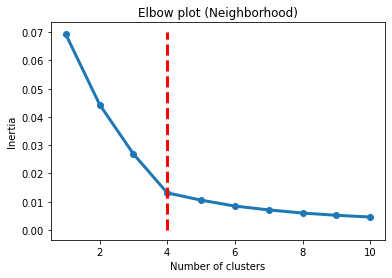

In [21]:
# distortion calculation for a range of number of cluster
inertia = []
for i in np.arange(1, 11):
    km = KMeans(
        n_clusters=i
    )
    km.fit(X)
    inertia.append(km.inertia_)

# plot
plt.plot(np.arange(1, 11), inertia, marker='o', lw=3)
plt.plot([4, 4], [0, 0.07], 'k--',c='red', lw=3)
plt.title('Elbow plot (Neighborhood)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


Note:
According to the graph, the ideal cluster number is 4

In [22]:
# add clustering labels
df.insert(5, 'ClusterLabels', kmeans.labels_)
df

,PostalCode,Borough,Neighborhood,Latitude,Longitude,ClusterLabels
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264,2
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.65739,-79.37804,2
2,M5C,Downtown Toronto,St. James Town,43.65215,-79.37587,2
3,M4E,East Toronto,The Beaches,43.67709,-79.29547,3
4,M5E,Downtown Toronto,Berczy Park,43.64536,-79.37306,2
5,M5G,Downtown Toronto,Central Bay Street,43.65609,-79.38493,2
6,M6G,Downtown Toronto,Christie,43.66869,-79.42071,1
7,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.64970,-79.38258,2
8,M6H,West Toronto,"Dufferin, Dovercourt Village",43.66505,-79.43891,1
9,M4J,East York/East Toronto,The Danforth East,43.68811,-79.33418,3


In [23]:
# create map with clusters
map_clusters = folium.Map(location=[trt_latitude, trt_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df['Latitude'], df['Longitude'], df['Neighborhood'], df['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters